# Data preparation for the SDG Indicators by (1) UN and (2) WorldBank

## (1) UN data set

**We use UN SDG's data set and convert this data set, so every country, continent, etc. is in a separate <code>csv</code> file.**

To get started, we download the entire available data from https://unstats.un.org/sdgs/indicators/database/ and call it <code>un_data.csv</code>.


Let's load the data set and look at its columns and rows to figure out how it is structured.


**We aim to have one pandas data frame per country, with all indicators. We save them as separate <code>csv</code> files.** 

Let's start with the usual imports and loading the data set.

In [1]:
import numpy as np
import pandas as pd
import math
import os
import pickle
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading data set
all_data = pd.read_csv('utils/data/un_data.csv', dtype=object)
all_data.tail()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,[Name of international institution],[Name of non-communicable disease],[Policy Domains],[Quantile],[Reporting Type],[Sex],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
1083602,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2013,85.76164,2013,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1083603,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2014,125.47225,2014,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1083604,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2015,94.86903,2015,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1083605,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2016,93.93723,2016,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1083606,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2017,98.11231,2017,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN


The data set is structured by indicators and years in rows in one large data frame with all countries. We would like to have one data frame per country. Hence, we first extract the names of *regional groupings*, i.e. countries, continents, etc., and the names of so-called *other groupings*.

According to the UN Statistics Division, other groupings include Least Developed Countries (LDC), Land Locked Developing Countries (LLDC), Small Island Developing States (SIDS), Developed Regions, and Developing Regions. 

Developing Regions are Latin America and the Caribbean, South-Eastern Asia, Southern Asia, Southern Asia (excluding India), Caucasus and Central Asia, Eastern Asia (excluding Japan and China), Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia), Eastern Asia (excluding Japan), Oceania (exc. Australia and New Zealand), Sub-Saharan Africa (inc. Sudan), and Northern Africa (exc. Sudan).

**All these groupings can be subject to separate network analyses of the indicators later on.**




Let's first see all different columns of our data frame before we only see these different groupings.

In [3]:
list(all_data)

['Goal',
 'Target',
 'Indicator',
 'SeriesCode',
 'SeriesDescription',
 'GeoAreaCode',
 'GeoAreaName',
 'TimePeriod',
 'Value',
 'Time_Detail',
 ' UpperBound',
 ' LowerBound',
 ' BasePeriod',
 ' Source',
 'FootNote',
 'Nature',
 'Units',
 '[Age]',
 '[Cities]',
 '[Disability status]',
 '[Education level]',
 '[IHR Capacity]',
 '[Level/Status]',
 '[Location]',
 '[Migratory status]',
 '[Mode of transportation]',
 '[Name of international institution]',
 '[Name of non-communicable disease]',
 '[Policy Domains]',
 '[Quantile]',
 '[Reporting Type]',
 '[Sex]',
 '[Type of occupation]',
 '[Type of product]',
 '[Type of skill]',
 '[Type of speed]']

We have even lots of information on a sub-indicator level and this might be subject to more detailed analyses later on. We could, e.g., indicator 4.6.1* explore by disparate age goups and by sex.

\* *Indicator 4.6.1: Proportion of population in a given age group achieving at least a fixed level of proficiency in functional (a) literacy and (b) numeracy skills, by sex.*


We keep this possibility open, but now, let's not go further into a sub-indicator level and see the different groupings.

In [4]:
groupings = list(all_data['GeoAreaName'].unique())
groupings

['World',
 'South America',
 'Albania',
 'Oceania',
 'Western Africa',
 'Algeria',
 'Central America',
 'Eastern Africa',
 'Northern Africa',
 'Middle Africa',
 'Southern Africa',
 'Northern America',
 'Angola',
 'Caribbean',
 'Eastern Asia',
 'Azerbaijan',
 'Argentina',
 'Southern Asia',
 'South-Eastern Asia',
 'Australia',
 'Southern Europe',
 'Austria',
 'Bangladesh',
 'Armenia',
 'Australia and New Zealand',
 'Melanesia',
 'Belgium',
 'Polynesia',
 'Central and Southern Asia',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Solomon Islands',
 'Bulgaria',
 'Myanmar',
 'Burundi',
 'Belarus',
 'Cameroon',
 'Canada',
 'Cabo Verde',
 'Caucasus and Central Asia',
 'Central African Republic',
 'Asia',
 'Central Asia',
 'Sri Lanka',
 'Western Asia',
 'Chad',
 'Europe',
 'Eastern Europe',
 'Chile',
 'Northern Europe',
 'Western Europe',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Democratic Republic of the Congo',
 'Costa Rica',
 'Croa

In [5]:
# only take World Bank countries
c = pd.read_csv('utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 '

In [6]:
all_data.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)

In [7]:
# list of keys to delete
delete_groups = []

for g in list(groupings):
    if g not in countries:
        delete_groups.append(g)
        
# delete
for dg in delete_groups:
    groupings.remove(dg)

We convert the data set into multiple small data sets by creating a dictionary that contains the groupings' names as keys. 

First, we create empty data frames for each key.

In [8]:
dict_all = {c: pd.DataFrame() for c in countries}

In [9]:
# check, should be empty
dict_all.get('Belize')

""


Second, we replace each of the empty data frames with the data we have available for them. Note, that our dictionary will be the ensamble of all groupings.

In [10]:
for c in countries:    # memory-intensive
    dict_all[c] = all_data[all_data['GeoAreaName'].isin(['{}'.format(c)])]

In [11]:
# check
dict_all['Bolivia']

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,[Name of international institution],[Name of non-communicable disease],[Policy Domains],[Quantile],[Reporting Type],[Sex],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
224,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,68,Bolivia,2000,28.6,2000,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
225,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,68,Bolivia,2001,22.8,2001,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
226,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,68,Bolivia,2002,24.7,2002,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
227,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,68,Bolivia,2004,13.7,2004,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
228,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,68,Bolivia,2005,19.3,2005,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080881,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,68,Bolivia,2013,142.60478,2013,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1080882,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,68,Bolivia,2014,212.98375,2014,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1080883,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,68,Bolivia,2015,152.66092,2015,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1080884,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,68,Bolivia,2016,85.47392,2016,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN


Now, we have one data frame per country. The next step is to have years as columns.

The next cell gives us the series codes in the rows and the years in the columns. These series codes are unique descriptions of the sub-indicators and we match these series codes to indicators and all other information in a different data frame.

In [12]:
for c in countries:
    dict_all[c] = dict_all.get(c).pivot_table(values='Value', index='SeriesCode', columns='TimePeriod', dropna=False, aggfunc='first')

In [13]:
# check
dict_all['Bolivia'].head()

TimePeriod,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SeriesCode,,,,,,,,,,,,,,,,,,,,
AG_FPA_CFPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,-0.4,NaN,NaN
AG_FPA_COMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,-0.1,NaN,NaN
AG_LND_DGRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN
AG_LND_FRST,55.47032,NaN,NaN,NaN,NaN,54.21767,NaN,NaN,NaN,NaN,51.88683,NaN,NaN,NaN,NaN,50.55294,NaN,NaN,NaN,NaN
AG_LND_FRSTBIOPHA,133.25,NaN,NaN,NaN,NaN,133.26,NaN,NaN,NaN,NaN,135.6,NaN,NaN,NaN,NaN,135.6,NaN,NaN,NaN,NaN


Let's now save a data frame with all of the meta-information. We delete the columns which are specific in area and time, and of course we do not want to have the values in this data frame. In the end, we delete all duplicate entries in the column **SeriesCode**. So, we are left with the information we wanted: mapping the series codes to the indicators, the Source for the data, the Units measured in, etc.

In [14]:
info = all_data.drop(columns=['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'Time_Detail']).drop_duplicates(subset=['Indicator', 'SeriesCode'])

In [15]:
# check
info.head()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,UpperBound,LowerBound,BasePeriod,Source,FootNote,...,[Name of international institution],[Name of non-communicable disease],[Policy Domains],[Quantile],[Reporting Type],[Sex],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,NaN,NaN,NaN,"World Development Indicators database, World Bank","Retrieved on March 20, 2019 from World Bank, P...",...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
1448,1,1.1,1.1.1,SI_POV_EMP1,Employed population below international povert...,NaN,NaN,NaN,"ILO estimates, November 2018, available in ILO...",NaN,...,NaN,NaN,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN
10619,1,1.2,1.2.1,SI_POV_NAHC,Proportion of population living below the nati...,NaN,NaN,NaN,"World Development Indicators database, World Bank",Source: National Statictis and Information Aut...,...,NaN,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN
11921,1,1.3,1.3.1,SI_COV_MATNL,[ILO] Proportion of mothers with newborns rece...,NaN,NaN,NaN,ILO estimates based on country data compled th...,NaN,...,NaN,NaN,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN
12028,1,1.3,1.3.1,SI_COV_POOR,[ILO] Proportion of poor population receiving ...,NaN,NaN,NaN,ILO Social Security Inquiry (SSI). Available a...,ILO estimates based on country data,...,NaN,NaN,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN


## Cleaning up and transforming all country data frames into the same dimensions

We have a couple of things to do to make our data frames workable:
1. We have some values in the data frames which we do not want, as e.g. <code>,</code>, <code> = </code>, <code>N</code>, etc. We replace them with appropriate values, i.e. <code>0</code>, or simply a space. 
2. Some data frames have data from **1990** to **2018**, some others from **1992** to **2018**. We want to have all data frames having data from **1990** to **2018**, i.e. an equal amount of columns. The additional columns are filled with <code>NaNs</code>.
3. Some data frames have not all indicators and sub-indicators listed, but we would like to have all of them in all data frames. These additional rows are filled with <code>NaNs</code>.

Let's start with the first task, i.e. cleaning up the data frames.

We first need to define lists for all years, i.e. **1990** to **2018** and all indicators and sub-indicators, i.e. series codes.

In [16]:
# list of all years
years = list(dict_all['France'])    # France is an example of a country that has all columns

Change <span style="color:red"> 'Haiti' </span> in the cell below to a few other countries and you'll see that they can have different lengths. We need to bring all on the same length. We agree on having data for the **years 1990 to 2018**.

Now, we insert the missing years for all groupings. We want to have NaNs in those columns.

In [17]:
# example
list(dict_all['Haiti'])

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [18]:
# list of all series codes
seriescodes = set(list(info['SeriesCode']))
seriescodes

{'AG_FPA_CFPI',
 'AG_FPA_COMM',
 'AG_LND_DGRD',
 'AG_LND_FRST',
 'AG_LND_FRSTBIOPHA',
 'AG_LND_FRSTCERT',
 'AG_LND_FRSTCHG',
 'AG_LND_FRSTMGT',
 'AG_LND_FRSTN',
 'AG_LND_FRSTPRCT',
 'AG_LND_TOTL',
 'AG_PRD_AGVAS',
 'AG_PRD_FIESSI',
 'AG_PRD_FIESSIN',
 'AG_PRD_ORTIND',
 'AG_PRD_XSUBDY',
 'AG_XPD_AGSGB',
 'BX_TRF_PWKR',
 'DC_FTA_TOTAL',
 'DC_ODA_BDVDL',
 'DC_ODA_BDVL',
 'DC_ODA_LDCG',
 'DC_ODA_LDCS',
 'DC_ODA_LLDC',
 'DC_ODA_LLDCG',
 'DC_ODA_SIDS',
 'DC_ODA_SIDSG',
 'DC_ODA_TOTG',
 'DC_ODA_TOTGGE',
 'DC_ODA_TOTL',
 'DC_ODA_TOTLGE',
 'DC_TOF_AGRL',
 'DC_TOF_HLTHL',
 'DC_TOF_HLTHNT',
 'DC_TOF_INFRAL',
 'DC_TOF_SCHIPSL',
 'DC_TOF_TRDCMDL',
 'DC_TOF_TRDCML',
 'DC_TOF_TRDDBMDL',
 'DC_TOF_TRDDBML',
 'DC_TOF_WASHL',
 'DC_TRF_TFDV',
 'DC_TRF_TOTDL',
 'DC_TRF_TOTL',
 'DT_TDS_DECT',
 'EG_EGY_CLEAN',
 'EG_EGY_PRIM',
 'EG_ELC_ACCS',
 'EG_FEC_RNEW',
 'EG_IFF_RANDN',
 'EG_TBA_H2CO',
 'EG_TBA_H2COAQ',
 'EG_TBA_H2CORL',
 'EN_ATM_CO2',
 'EN_ATM_CO2GDP',
 'EN_ATM_CO2MVA',
 'EN_ATM_PM25',
 'EN_H2O_GRAMBQ',

In [19]:
# count how many we have
len(seriescodes)

385

Firstly, we insert the missing years as columns for all groupings.

In [20]:
for c in countries:    # memory-intensive
    for year in years:
        if year not in list(dict_all[c]):
            dict_all[c]['{}'.format(year)] = np.nan
    # having the years in order
    dict_all[c] = dict_all[c][['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]

In [21]:
# check
dict_all['Nicaragua'].head()

TimePeriod,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SeriesCode,,,,,,,,,,,,,,,,,,,,
AG_FPA_CFPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.6,-1.2,NaN,NaN
AG_FPA_COMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2,-0.1,NaN,NaN
AG_LND_DGRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_LND_FRST,31.69353,NaN,NaN,NaN,NaN,28.78511,NaN,NaN,NaN,NaN,25.87668,NaN,NaN,NaN,NaN,25.87668,NaN,NaN,NaN,NaN
AG_LND_FRSTBIOPHA,192.45,NaN,NaN,NaN,NaN,192.44,NaN,NaN,NaN,NaN,192.45,NaN,NaN,NaN,NaN,192.45,NaN,NaN,NaN,NaN


Secondly, we insert the missing series codes as rows.

Let's first see how many rows do we have for <span style="color:red"> Guam </span>?

In [22]:
len(list(dict_all['Nicaragua'].index))

235

Let's have all $J$ sub-indicators we want for each country as rows. We fill these rows with NaNs. 

In [23]:
for c in countries:        # memory-intensive
    for seriescode in seriescodes:
        if seriescode not in list(dict_all[c].index):
            dict_all[c].loc[seriescode] = np.nan    # fill these rows with NaNs

In [24]:
# check: do we have J many?
len(list(dict_all['Nicaragua'].index))

385

In [25]:
# convert all to floats
for c in countries:
    for year in years:    
        for seriescode in seriescodes:
            if not isinstance(dict_all[c].loc[seriescode, year], float):
                dict_all[c].loc[seriescode, year] = float(dict_all[c].loc[seriescode, year].replace(',', '').replace('<', '').replace('>', '').replace('=', '').replace('N', '0').replace(' -   ', '0').replace('0V', '0').replace('. . .', '0'))

In [26]:
# double-check: are all series codes as rows?
len(list(dict_all['Nicaragua'].index))

385

Finally, we can save all countries as different <code>csv</code> files and as one `dict`.

In [27]:
if not os.path.exists('csv_original'):
    os.mkdir('csv_original')

In [28]:
for c in countries:
    dict_all[c].to_csv(r'csv_original/{}.csv'.format(c))

Having the information file might also be helpful.

In [29]:
if not os.path.exists('utils'):
    os.mkdir('utils')
    
info.to_csv(r'utils/info.csv')

In [30]:
# as one pickle file
dictall = open('utils/data/dict_all.pkl', 'wb')
pickle.dump(dict_all, dictall)
dictall.close()

In [ ]:
# CHECKPOINT
dictall = open('utils/data/dict_all.pkl', 'rb')
dict_all = pickle.load(dictall)
dictall.close()

## Visualising time-series

We quickly visualise the time-series to get a better idea of the characteristics of our data set.

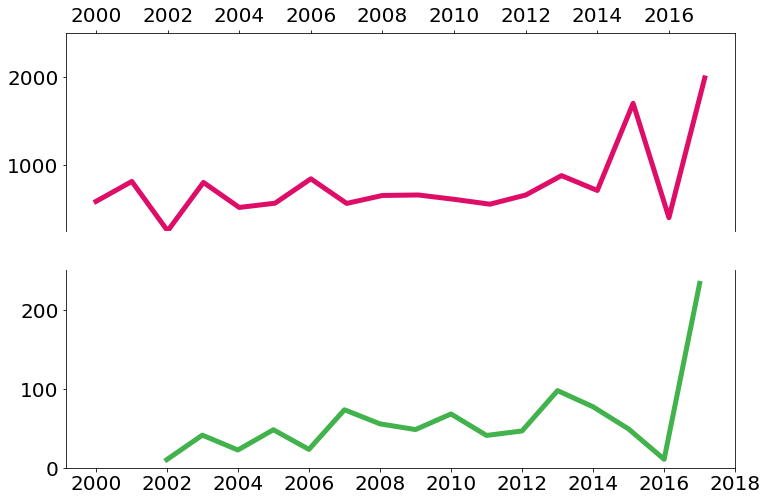

In [31]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax2.plot(list(range(2000, 2020)), dict_all['Bolivia'].loc['DC_ODA_BDVL'], color='#42B24C', linewidth=5)
ax.plot(list(range(2000, 2020)), dict_all['Bolivia'].loc['DC_TRF_TOTL'], color='#DE0E68', linewidth=5)

ax2.set_ylim(0, 251)  # biodiversity ODA
ax.set_ylim(250, 2501)  # total ODA

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labelsize=20, labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

plt.xticks(np.arange(2000, 2019, step=2), size=20)
ax2.tick_params(labelsize=20)

f.set_figheight(8)
f.set_figwidth(12)

plt.show()

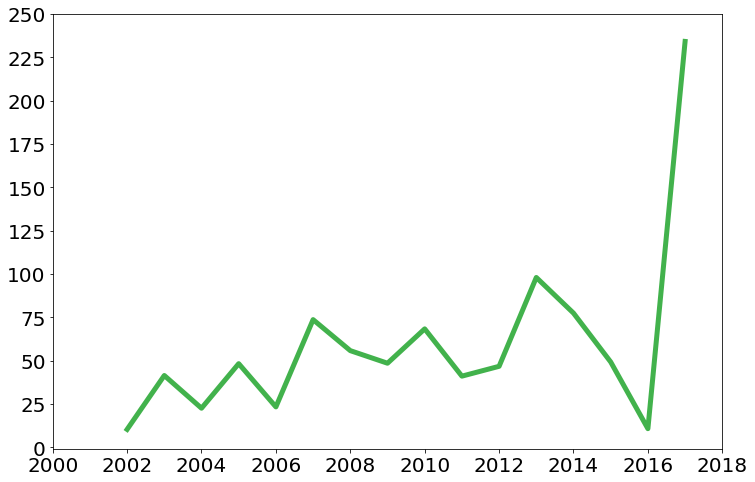

In [32]:
plt.figure(figsize=(12,8))
plt.plot(list(range(2000, 2020)), dict_all['Bolivia'].loc['DC_ODA_BDVL'], color='#42B24C', linewidth=5)
plt.xticks(np.arange(2000, 2019, step=2), size=20)
plt.yticks(np.arange(0, 251, step=25), size=20)
plt.show()

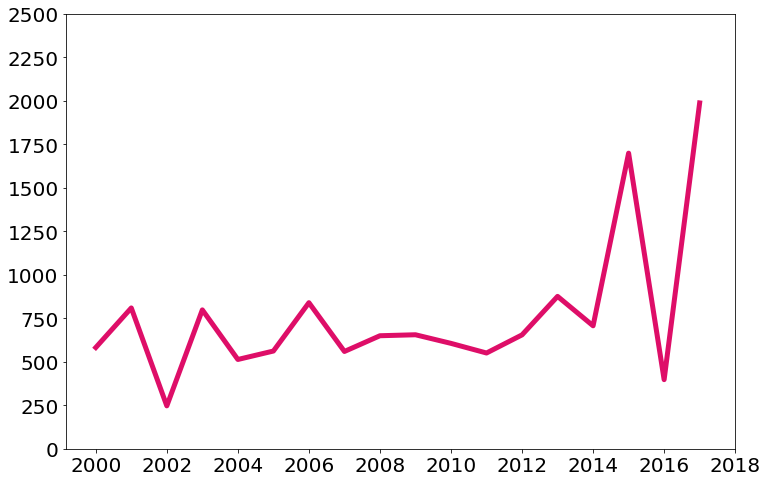

In [33]:
plt.figure(figsize=(12,8))
plt.plot(list(range(2000, 2020)), dict_all['Bolivia'].loc['DC_TRF_TOTL'], color='#DE0E68', linewidth=5)
plt.xticks(np.arange(2000, 2019, step=2), size=20)
plt.yticks(np.arange(0, 2501, step=250), size=20)
plt.show()

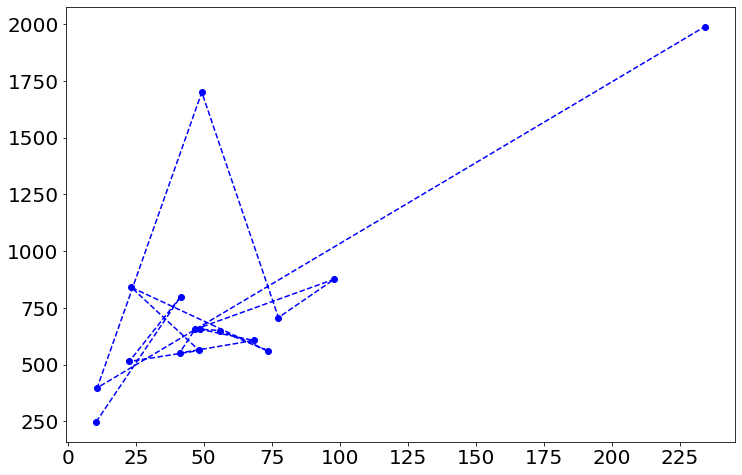

In [34]:
plt.figure(figsize=(12,8))
plt.yticks(np.arange(0, 2001, step=250), size=20)
plt.xticks(np.arange(0, 251, step=25), size=20)
plt.plot(dict_all['Bolivia'].loc['DC_ODA_BDVL'], dict_all['Bolivia'].loc['DC_TRF_TOTL'], '--bo'); #, s=100, color='black')

## Data standardisation
We have saved the original data set, but it is often useful to have the data standardised. Standardising a data set involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. Standardisation is often required by machine learning algorithms when your time series data has input values with differing scales. 

We create a new dictionary `dict_all_std` to keep the standardised values separate to the original ones.

In [ ]:
# CHECKPOINT (we don't want to re-run the entire script every time we continue working on it)
dict_all = pickle.load(open('utils/data/dict_all.pkl', 'rb'))
dict_all_std = pickle.load(open('utils/data/dict_all_std.pkl', 'rb'))

In [37]:
# ~15 minutes computing time
dict_all_std = copy.deepcopy(dict_all)    

for country in countries:
    for seriescode in seriescodes:
        # adding noise as representative for measurement errors
        #noise = np.random.normal(scale=0.1, size=len(dict_all[group].loc[seriescode]))
        
        #dict_all[country].loc[seriescode] = dict_all[country].loc[seriescode] + noise
        
        dict_all_std[country].loc[seriescode] = scale(dict_all[country].loc[seriescode])

In [38]:
#check
print('Original value', dict_all['France'].loc['AG_LND_FRST'])
print('-------')
print('Standardised value', dict_all_std['France'].loc['AG_LND_FRST'])

Original value TimePeriod
2000    27.9223
2001        NaN
2002        NaN
2003        NaN
2004        NaN
2005     28.967
2006        NaN
2007        NaN
2008        NaN
2009        NaN
2010    29.9952
2011        NaN
2012        NaN
2013        NaN
2014        NaN
2015     31.027
2016        NaN
2017        NaN
2018        NaN
2019        NaN
Name: AG_LND_FRST, dtype: object
-------
Standardised value TimePeriod
2000    -1.34526
2001         NaN
2002         NaN
2003         NaN
2004         NaN
2005   -0.441843
2006         NaN
2007         NaN
2008         NaN
2009         NaN
2010    0.447369
2011         NaN
2012         NaN
2013         NaN
2014         NaN
2015     1.33974
2016         NaN
2017         NaN
2018         NaN
2019         NaN
Name: AG_LND_FRST, dtype: object


We better save `dict_all_std`...

In [39]:
# as csv files per grouping
if not os.path.exists('csv_standardised'):
    os.mkdir('csv_standardised')
    
for group in groupings:
    dict_all_std[group].to_csv(r'csv_standardised/{}.csv'.format(group))

# as one pickle file
stand = open('utils/data/dict_all_std.pkl', 'wb')
pickle.dump(dict_all_std, stand)
stand.close()

## (2) World Bank data set

**We use World Bank's data set and convert this data set, so every country, continent, etc. is in a separate <code>csv</code> file.**

To get started, we download the entire available data from http://datatopics.worldbank.org/sdgs/ and call it <code>wb_data.csv</code>.


Let's load the data set and look at its columns and rows to figure out how it is structured.


**We aim to have one pandas data frame per country, with all indicators. We save them as separate <code>csv</code> files.** 

In [40]:
# loading data set
wb_data = pd.read_csv('utils/data/wb_data.csv', dtype=object)
wb_data.drop(wb_data.tail(5).index,inplace=True)    # 5 last rows are blank / have other info
wb_data.tail()

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
98620,Zimbabwe,ZWE,"Wage and salaried workers, total (% of total e...",SL.EMP.WORK.ZS,38.8390007019043,38.4389991760254,37.6669998168945,36.9830017089844,36.9080009460449,37.0449981689453,...,34.1699981689453,34.1469993591309,34.007999420166,34.0499992370605,33.9790000915527,33.898998260498,33.8489990234375,33.8880004882813,33.8720016479492,33.8489990234375
98621,Zimbabwe,ZWE,"Water productivity, total (constant 2010 US$ G...",ER.GDP.FWTL.M3.KD,..,..,3.78390387828548,..,..,..,...,..,..,..,..,..,..,..,..,..,..
98622,Zimbabwe,ZWE,Women making their own informed decisions rega...,SG.DMK.SRCR.FN.ZS,..,..,..,..,..,..,...,..,58.8,..,..,..,59.9,..,..,..,..
98623,Zimbabwe,ZWE,Women who were first married by age 15 (% of w...,SP.M15.2024.FE.ZS,..,..,..,..,..,..,...,..,3.9,..,..,..,3.7,..,..,..,..
98624,Zimbabwe,ZWE,Women who were first married by age 18 (% of w...,SP.M18.2024.FE.ZS,..,..,..,..,..,..,...,..,30.5,..,..,33.5,32.4,..,..,..,..


In [41]:
columns = list(wb_data.columns)
for column in columns[4:]:
    columns.append(column[:4])
    columns.remove(column)

wb_data.columns = columns

In [42]:
years = columns[4:]

In [43]:
# meta-data
wb_info = pd.read_csv('utils/wb_info.csv', dtype=object)
wb_info = wb_info.drop(columns=['Topic', 'Indicator Name'])

In [44]:
all_countries = list(wb_data['Country Name'].unique())
# save countries
np.savetxt('utils/countries_wb_all.csv', all_countries, delimiter=';', fmt='%s')

In [46]:
dict_all_wb['Afghanistan']

TimePeriod,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
EG.CFT.ACCS.ZS,8.8,9.51,10.39,11.46,12.43,13.49,14.81,15.99,17.44,18.84,20.68,22.33,24.08,26.17,27.99,30.1,32.44,..,..,..
EG.ELC.ACCS.ZS,..,..,..,..,..,23,26.9293174743652,33.0157508850098,42.4,45.2371215820313,42.7,43.2220189082037,69.1,70.1534805297852,89.5,71.5,97.7,97.7,..,..
EG.ELC.ACCS.RU.ZS,..,..,..,..,..,8.02072617359793,11.1930788250914,18.3846727932146,27.9542515209591,32.9043678269207,30.2188001325129,29.5728813319651,60.8491561955971,62.8756933574353,86.5005120344614,64.5733535573634,97.0993598483561,97.0919732851744,..,..
EG.ELC.ACCS.UR.ZS,..,..,..,..,..,74,79.889274597168,81.6870498657227,89.9,85.3217163085938,82.8,86.5677791512155,95,92.7357330322266,98.7,92.5,99.5,99.5,..,..
FX.OWN.TOTL.ZS,..,..,..,..,..,..,..,..,..,..,..,9.00501251220703,..,..,9.96100044250488,..,..,14.8933124542236,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP.M15.2024.FE.ZS,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,8.8,..,..,..,..
SP.M18.2024.FE.ZS,..,..,..,..,..,..,..,..,39,..,..,40.4,..,..,32.8,34.8,..,..,..,..
VC_DSR_MTMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051,NaN,NaN
VC_DSR_DAFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN,NaN


In [49]:
dict_all_wb = {country: pd.DataFrame() for country in countries}
for country in countries:
    print(country)
    dict_all_wb[country] = wb_data[wb_data['Country Name'].isin(['{}'.format(country)])]
    dict_all_wb[country] = dict_all_wb[country].drop(columns=['Country Name', 'Country Code', 'Series Name'])
    dict_all_wb[country].set_index('Series Code', inplace=True)
    dict_all_wb[country] = dict_all_wb[country].append(dict_all[country].loc[['VC_DSR_MTMP', 'VC_DSR_DAFF', 'SG_DSR_SILS']])    # adding series codes for SDG 13
    dict_all_wb[country] = dict_all_wb[country].replace('..', np.nan).astype(float)

Afghanistan
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas, The
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo, Dem. Rep.
Congo, Rep.
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czech Republic
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt, Arab Rep.
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
Gabon
Gambia, The
Georgia
Germany
Ghana
Greece
Greenland
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Rep.
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Korea, Dem. People's Rep.
Kuwait
Kyrgyz Republic
Lao PDR
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
Madagascar
Malawi
Malaysia
Maldives
M

In [50]:
seriescodes_wb = set(list(dict_all_wb['Germany'].index))

In [51]:
# saving data
for country in countries: 
    dict_all_wb[country].to_csv(r'csv_original/{}_wb.csv'.format(country))
    
# as one pickle file
dictall = open('utils/data/dict_all_wb.pkl', 'wb')
pickle.dump(dict_all_wb, dictall)
dictall.close()

## Data standardisation

In [53]:
dict_all_wb_std = copy.deepcopy(dict_all_wb)

for country in countries:
    for seriescode in seriescodes_wb:
        # adding noise as representative for measurement errors
        #noise = np.random.normal(scale=0.1, size=len(dict_all_wb[country].loc[seriescode]))
        
        #dict_all_wb[country].loc[seriescode] = dict_all_wb[country].loc[seriescode] + noise
        
        dict_all_wb_std[country].loc[seriescode] = scale(dict_all_wb[country].loc[seriescode])

In [54]:
#check
print('Original value', dict_all_wb['Belgium'].loc['EN.CLC.MDAT.ZS'])
print('-------')
print('Standardised value', dict_all_wb_std['Belgium'].loc['EN.CLC.MDAT.ZS'])

Original value TimePeriod
2000         NaN
2001         NaN
2002         NaN
2003         NaN
2004         NaN
2005         NaN
2006         NaN
2007         NaN
2008         NaN
2009    0.001692
2010         NaN
2011         NaN
2012         NaN
2013         NaN
2014         NaN
2015         NaN
2016         NaN
2017         NaN
2018         NaN
2019         NaN
Name: EN.CLC.MDAT.ZS, dtype: float64
-------
Standardised value TimePeriod
2000    NaN
2001    NaN
2002    NaN
2003    NaN
2004    NaN
2005    NaN
2006    NaN
2007    NaN
2008    NaN
2009    0.0
2010    NaN
2011    NaN
2012    NaN
2013    NaN
2014    NaN
2015    NaN
2016    NaN
2017    NaN
2018    NaN
2019    NaN
Name: EN.CLC.MDAT.ZS, dtype: float64


We better save `dict_all_wb_std`.

In [55]:
# as csv files per grouping
if not os.path.exists('csv_standardised'):
    os.mkdir('csv_standardised')
    
for country in countries:
    dict_all_wb_std[country].to_csv(r'csv_standardised/{}_wb.csv'.format(country))

# as one pickle file
stand = open('utils/data/dict_all_wb_std.pkl', 'wb')
pickle.dump(dict_all_wb_std, stand)
stand.close()